In [10]:
import csv
import sqlite3
import pandas as pd
import numpy as np
conn = sqlite3.connect('customers'+ '.sqlite')

In [2]:
import sqlite3
import csv
#import pyodbc

conn = sqlite3.connect('customers'+ '.sqlite')

cur = conn.cursor()
cur.execute('CREATE TABLE Bill_Sales(Bill int primary key, Sales float, Customer varchar(10))')

with open('Bill_Sales.csv','r') as fin: # `with` statement available in 2.5+
    # csv.DictReader uses first line in file for column headings by default
    dr = csv.DictReader(fin) # comma is default delimiter
    to_db = [(i['Bill'], i['Sales'], i['Customer']) for i in dr]

cur.executemany("INSERT INTO Bill_Sales (Bill, Sales, Customer) VALUES (?, ?, ?);", to_db)
conn.commit()

In [3]:
cur = conn.cursor()
cur.execute('CREATE TABLE Freight(Delivery varchar(15) , Road double, Parcel double, Sea double, Air double)');

In [4]:
with open('Freight.csv', 'r') as fin:  # `with` statement available in 2.5+
    # csv.DictReader uses first line in file for column headings by default
    dr = csv.DictReader(fin)  # comma is default delimiter
    to_db = []
    for item in dr:
        for delivery in item['Delivery'].split('|'):
            #print((delivery, item['Road'], item['Parcel'], item['Sea'], item['Air']))
            to_db.append((delivery, item['Road'], item['Parcel'], item['Sea'], item['Air']))
    print('Successful!')

Successful!


In [5]:
cur.executemany("INSERT INTO Freight (Delivery, Road, Parcel, Sea, Air) VALUES (?, ?, ?, ?, ?);", to_db);

In [6]:
cur.execute('CREATE TABLE Bill_Delivery_items(Bill , Delivery int, Items int)')

with open('Bill_Delivery_Items.csv','r') as fin: # `with` statement available in 2.5+
    # csv.DictReader uses first line in file for column headings by default
    dr = csv.DictReader(fin) # comma is default delimiter
    to_db = [(i['Bill'], i['Delivery'], i['Items']) for i in dr]

cur.executemany("INSERT INTO Bill_Delivery_items (Bill, Delivery, Items) VALUES (?, ?, ?);", to_db)
conn.commit()
#conn.close()


In [7]:
cur.execute("SELECT * FROM Freight;" )

In [8]:
df0 = pd.DataFrame(data = cur.fetchall(), columns = [x[0] for x in cur.description])
df0.head()

,Delivery,Road,Parcel,Sea,Air
0,64581971278,NULL,NULL,42.2,NULL
1,100086743691,48.93,NULL,NULL,NULL
2,87370225,NULL,7.74,NULL,NULL
3,61929359,NULL,7.74,NULL,NULL
4,100060965448,NULL,NULL,38.19,NULL


Freight tables have mistake in Delivery ids. We consider only the last 8 characters from left as that seems to be the valid id.

In [13]:
df0['Delivery']=df0['Delivery'].str[-8:]
#df0['Delivery']=df0['Delivery'].str

df0=df0.replace('NULL',np.nan)
df0.dtypes

Delivery     object
Road        float64
Parcel      float64
Sea         float64
Air         float64
dtype: object

In [14]:
df0.head()

,Delivery,Road,Parcel,Sea,Air
0,81971278,NaN,NaN,42.20,NaN
1,86743691,48.93,NaN,NaN,NaN
2,87370225,NaN,7.74,NaN,NaN
3,61929359,NaN,7.74,NaN,NaN
4,60965448,NaN,NaN,38.19,NaN


In [28]:
cur.execute("SELECT * FROM Bill_Delivery_Items inner join Freight using(Delivery);")

In [29]:
cur.description

(('Bill', None, None, None, None, None, None),
 ('Delivery', None, None, None, None, None, None),
 ('Items', None, None, None, None, None, None),
 ('Road', None, None, None, None, None, None),
 ('Parcel', None, None, None, None, None, None),
 ('Sea', None, None, None, None, None, None),
 ('Air', None, None, None, None, None, None))

In [30]:
df = pd.DataFrame(data = cur.fetchall(), columns = [x[0] for x in cur.description])
df.head()

,Bill,Delivery,Items,Road,Parcel,Sea,Air
0,7581947713,87370225,10,NULL,7.74,NULL,NULL
1,7581947713,87370225,20,NULL,7.74,NULL,NULL
2,7581947713,87370225,30,NULL,7.74,NULL,NULL
3,7581947713,87370225,40,NULL,7.74,NULL,NULL
4,7581947713,87370225,50,NULL,7.74,NULL,NULL


In [31]:
import numpy as np
df=df.replace('NULL',np.nan)
df.head()

,Bill,Delivery,Items,Road,Parcel,Sea,Air
0,7581947713,87370225,10,NaN,7.74,NaN,NaN
1,7581947713,87370225,20,NaN,7.74,NaN,NaN
2,7581947713,87370225,30,NaN,7.74,NaN,NaN
3,7581947713,87370225,40,NaN,7.74,NaN,NaN
4,7581947713,87370225,50,NaN,7.74,NaN,NaN


### Check the outliers in each of the delivery method

Now let's check outliers, symmetry and skewness of data

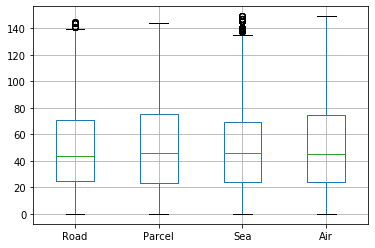

In [32]:
df.drop_duplicates().boxplot(column=['Road', 'Parcel', 'Sea', 'Air'])# This will make sure repeated rows are not taken

We can interpret the box plot that the data is quite good skewed in all the transportation mediums viz. Road, Parcel, Sea and Air. There are some outliers in Road and a lot in case of Sea. 

In [50]:
#df[['Road','Parcel','Sea','Air']].drop_duplicates().plot(kind='bar');
#We can see that expensive mostly ordered via parcel from the above plot

### Check which of the transportation means is popular

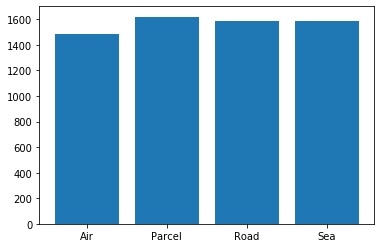

In [47]:
df1_=df.drop(['Bill','Items'], axis=1)
df1 = (df1_.melt(id_vars='Delivery')
       .drop_duplicates(subset=['Delivery', 'value'])
       .dropna()
       .groupby('variable', as_index=False)
       .size())
plt.bar(df1['variable'], df1['size']);

Seems all are almost equally popular. Among all, Air seems to be less popular and parcel seems to be slightly more popular.

One customer can have same bill and within same delivery the 

In [51]:
df.drop_duplicates(subset=['Bill','Delivery','Items'], keep = 'last', inplace = True)
df.head()

,Bill,Delivery,Items,Road,Parcel,Sea,Air
0,7581947713,87370225,10,NaN,7.74,NaN,NaN
1,7581947713,87370225,20,NaN,7.74,NaN,NaN
2,7581947713,87370225,30,NaN,7.74,NaN,NaN
3,7581947713,87370225,40,NaN,7.74,NaN,NaN
4,7581947713,87370225,50,NaN,7.74,NaN,NaN


In [52]:
cur.execute("SELECT * FROM Bill_Sales bs INNER JOIN Bill_Delivery_Items bdi ON bs.Bill=bdi.Bill;")

In [56]:
df1 = pd.DataFrame(data = cur.fetchall(), columns = [x[0] for x in cur.description])
df1.head()

,Bill,Sales,Customer,Bill,Delivery,Items
0,2227224699,5685.49,HV,2227224699,81971278,10
1,2190637856,11884.03,LK,2190637856,86743691,80
2,7581947713,1265.52,YRN,7581947713,87370225,60
3,7756222815,35393.02,GKD,7756222815,60965448,230
4,4365661405,20031.54,L,4365661405,81299578,520


In [57]:
df1.shape

(66697, 6)

### Lets check Anomolies in Sales

In [63]:
df1['Sales'].max() # Checks Maximum Sales

30488367.59

In [64]:
#Lets find out negative sales
is_neg  = df1['Sales']<=0
print(df1[is_neg])

             Bill     Sales Customer        Bill  Delivery  Items
883    5278766207      0.00      AGK  5278766207  60330214    190
1049   5278766207      0.00      AGK  5278766207  60330214     20
4503   5278766207      0.00      AGK  5278766207  60330214    220
6061   5278766207      0.00      AGK  5278766207  60330214     90
6338   9372915127      0.00      UQP  9372915127  82868979     10
6502   5278766207      0.00      AGK  5278766207  60330214    290
6801   5278766207      0.00      AGK  5278766207  60330214     50
11302  2446300991      0.00       QG  2446300991  69449922     10
16169  9021340138      0.00       LK  9021340138  87488147     40
16647  5278766207      0.00      AGK  5278766207  60330214    330
18117  5278766207      0.00      AGK  5278766207  60330214    320
18461  5278766207      0.00      AGK  5278766207  60330214    210
18740   578960406      0.00      BDP  0578960406  81699531     10
18947  5278766207      0.00      AGK  5278766207  60330214     70
20929  527

#### Maximum ordered item

In [65]:
df1['Items'].max()

3320

#### Lets find out top 10 popular Customers

In [101]:
n = 10
df1['Customer'].value_counts()[:n].index.tolist()

['A', 'KQA', 'ALF', 'T', 'TBV', 'TT', 'VR', 'RNM', 'OF', 'Q']

### Merge the two dataframes now ?

Now Lets merge the two dataframes df and df1

In [67]:
df.head(3)

,Bill,Delivery,Items,Road,Parcel,Sea,Air
0,7581947713,87370225,10,NaN,7.74,NaN,NaN
1,7581947713,87370225,20,NaN,7.74,NaN,NaN
2,7581947713,87370225,30,NaN,7.74,NaN,NaN


In [68]:
df1.head(3)

,Bill,Sales,Customer,Bill,Delivery,Items
0,2227224699,5685.49,HV,2227224699,81971278,10
1,2190637856,11884.03,LK,2190637856,86743691,80
2,7581947713,1265.52,YRN,7581947713,87370225,60


In [78]:
df2 = pd.merge(df, df1, on='Delivery')
df2.head()

,Bill_x,Delivery,Items_x,Road,Parcel,Sea,Air,Bill_y,Sales,Customer,Bill_y,Items_y
0,7581947713,87370225,10,NaN,7.74,NaN,NaN,7581947713,1265.52,YRN,7581947713,60
1,7581947713,87370225,10,NaN,7.74,NaN,NaN,7581947713,1265.52,YRN,7581947713,50
2,7581947713,87370225,10,NaN,7.74,NaN,NaN,7581947713,1265.52,YRN,7581947713,20
3,7581947713,87370225,10,NaN,7.74,NaN,NaN,7581947713,1265.52,YRN,7581947713,10
4,7581947713,87370225,10,NaN,7.74,NaN,NaN,7581947713,1265.52,YRN,7581947713,30


In [79]:
df2 = df2.drop_duplicates()

In [80]:
df2.head()

,Bill_x,Delivery,Items_x,Road,Parcel,Sea,Air,Bill_y,Sales,Customer,Bill_y,Items_y
0,7581947713,87370225,10,NaN,7.74,NaN,NaN,7581947713,1265.52,YRN,7581947713,60
1,7581947713,87370225,10,NaN,7.74,NaN,NaN,7581947713,1265.52,YRN,7581947713,50
2,7581947713,87370225,10,NaN,7.74,NaN,NaN,7581947713,1265.52,YRN,7581947713,20
3,7581947713,87370225,10,NaN,7.74,NaN,NaN,7581947713,1265.52,YRN,7581947713,10
4,7581947713,87370225,10,NaN,7.74,NaN,NaN,7581947713,1265.52,YRN,7581947713,30


In [82]:
df2.shape

(2734012, 12)